In [4]:
import lightgbm as lgb
import numpy as np
from binary_io import *

dataset = 'imagenet'
dataset = 'wikipedia'
dataset = 'gist1m'
M = 128
efc = 1000
efs = 1000
ck_ts = 2000
k = 10

# prefix = '/dk/lcj_rag/ANNS/test/'
data_prefix = '../Bert-ANNS/data/'
prefix = f'{dataset}.M_{M}.efc_{efc}.efs_{efs}.ck_ts_{ck_ts}.ncheck_100.recall@{k}'

train_feature = fvecs_read(f'{data_prefix}{prefix}.train_feats_nn.fvecs')
train_label = ivecs_read(f'{data_prefix}{prefix}.train_label.ivecs')[:, 0]
test_feature = fvecs_read(f'{data_prefix}{prefix}.test_feats_nn.fvecs')
test_label = ivecs_read(f'{data_prefix}{prefix}.test_label.ivecs')[:, 0]

# train_feature = train_feature[:, -100:]
# test_feature = test_feature[:, -100:]
print(len(train_feature), len(train_label))
print(np.sum(test_label), np.sum(train_label))
print(len(train_feature[0]), train_feature[0][-101:])

500000 500000
11 3665
1063 [1.2181722e+00 1.2243316e+00 1.2327800e+00 1.2438024e+00 1.2438416e+00
 1.2441821e+00 1.2452942e+00 1.2465439e+00 1.2544835e+00 1.2642384e+00
 1.2652555e+00 1.2669389e+00 1.2714139e+00 1.2723000e+00 1.2733494e+00
 1.2765998e+00 1.2780159e+00 1.2799301e+00 1.2815521e+00 1.2843854e+00
 1.2858818e+00 1.2866589e+00 1.2893658e+00 1.2905846e+00 1.2905972e+00
 1.2910478e+00 1.2915183e+00 1.2958870e+00 1.2994473e+00 1.3011293e+00
 1.3024429e+00 1.3034072e+00 1.3068814e+00 1.3073915e+00 1.3076603e+00
 1.3085535e+00 1.3096418e+00 1.3103490e+00 1.3104122e+00 1.3109767e+00
 1.3119597e+00 1.3128798e+00 1.3129383e+00 1.3181310e+00 1.3182509e+00
 1.3187566e+00 1.3200315e+00 1.3209324e+00 1.3209426e+00 1.3218732e+00
 1.3225029e+00 1.3235981e+00 1.3236032e+00 1.3268554e+00 1.3268692e+00
 1.3269725e+00 1.3283193e+00 1.3286076e+00 1.3305669e+00 1.3312529e+00
 1.3318822e+00 1.3328009e+00 1.3336062e+00 1.3343492e+00 1.3357062e+00
 1.3369205e+00 1.3370645e+00 1.3374552e+00 1.33752

In [5]:
params = {
    'boosting_type': 'gbdt',    # 使用 GBDT 算法
    'objective': 'binary',  # 二分类任务
    'metric': 'binary_logloss',            # 使用 binary_logloss 作为评估指标
    'learning_rate': 0.05,       # 学习率
    'num_boost_round': 3000,     # 提升迭代的轮数
    'verbose': 1,               # 控制处理信息的详细程度
    'num_threads': 128           # 设置线程数
}

In [6]:
gbm = lgb.train(params, lgb.Dataset(train_feature, label=train_label))

/home/zhengweiguo/miniconda3/envs/lcj_bert/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Number of positive: 3665, number of negative: 496335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.230460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 271053
[LightGBM] [Info] Number of data points in the train set: 500000, number of used features: 1063
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.007330 -> initscore=-4.908423
[LightGBM] [Info] Start training from score -4.908423


Area Under the Curve (AUC): 0.7022727272727272
0%->bruteforce | predict recall: 0.000000 | overall recall: 0.998900
2%->bruteforce | predict recall: 0.000000 | overall recall: 0.998900
4%->bruteforce | predict recall: 0.181818 | overall recall: 0.999100
6%->bruteforce | predict recall: 0.181818 | overall recall: 0.999100
8%->bruteforce | predict recall: 0.181818 | overall recall: 0.999100
10%->bruteforce | predict recall: 0.181818 | overall recall: 0.999100
12%->bruteforce | predict recall: 0.272727 | overall recall: 0.999200
14%->bruteforce | predict recall: 0.454545 | overall recall: 0.999400
16%->bruteforce | predict recall: 0.454545 | overall recall: 0.999400
18%->bruteforce | predict recall: 0.545455 | overall recall: 0.999500
20%->bruteforce | predict recall: 0.545455 | overall recall: 0.999500
22%->bruteforce | predict recall: 0.545455 | overall recall: 0.999500
24%->bruteforce | predict recall: 0.636364 | overall recall: 0.999600
26%->bruteforce | predict recall: 0.636364 | ove

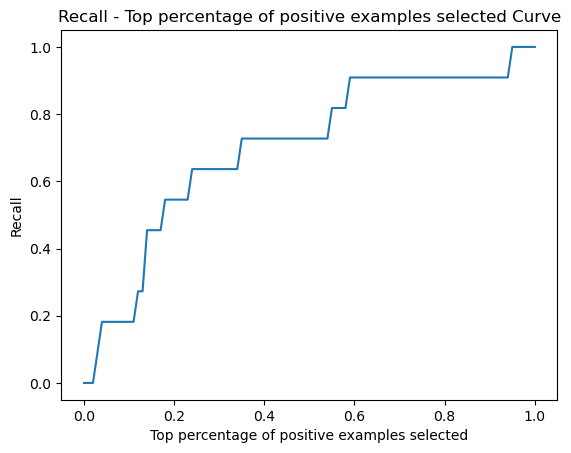

In [7]:
from sklearn.metrics import recall_score
import time
start = time.time()
label_pred = gbm.predict(test_feature)
end = time.time()

import numpy as np
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
from scipy.integrate import trapezoid as trapz

def recall_curve(test_label, label_pred):
    n = len(label_pred)
    recalls = []
    percentages = np.arange(0, 1.01, 0.01)  # 从0%到100%，步长为1%
    for p in percentages:
        threshold = np.percentile(label_pred, 100 * (1 - p))
        if p==0: threshold += 1
        new_label_pred = np.where(label_pred >= threshold, 1, 0)
        recall = recall_score(test_label, new_label_pred)
        recalls.append(recall)
    return percentages, recalls

percentages, recalls = recall_curve(test_label, label_pred)
auc = trapz(recalls, percentages)
print("Area Under the Curve (AUC):", auc)

total_true_label = np.sum(test_label)
step = 2
for p in range(0, 100 + step, step):
    fail = total_true_label * (1 - recalls[p])
    success = len(test_label) - fail
    overall_recall = (success * 1.000 + fail * 0.90) / len(test_label)
    print(f'{p}%->bruteforce | predict recall: {recalls[p]:4f} | overall recall: {overall_recall:6f}')

plt.plot(percentages, recalls)
plt.xlabel("Top percentage of positive examples selected")
plt.ylabel("Recall")

plt.title("Recall - Top percentage of positive examples selected Curve")
plt.show()

# recall = recall_score(test_label, label_pred.round())
# print("Recall:", recall)